In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from importlib import reload 

In [3]:
from deeprank.dataset import DataLoader, PairGenerator, ListGenerator
from deeprank import utils

In [4]:
seed = 1234
torch.manual_seed(seed)

In [5]:
loader = DataLoader('./config/letor07_mp_fold1.model')

[./data/letor/r5w/word_dict.txt]
	Word dict size: 193367
[./data/letor/r5w/qid_query.txt]
	Data size: 1692
[./data/letor/r5w/docid_doc.txt]
	Data size: 65323
[./data/letor/r5w/embed_wiki-pdc_d50_norm]
	Embedding size: 109282
[./data/letor/r5w/embed.idf]
	Embedding size: 193367
Generate numpy embed: (193368, 50)
Generate numpy embed: (193368, 1)


In [6]:
import json
letor_config = json.loads(open('./config/letor07_mp_fold1.model').read())
#device = torch.device("cuda")
#device = torch.device("cpu")
select_device = torch.device("cpu")
rank_device = torch.device("cuda")

In [7]:
Letor07Path = letor_config['data_dir']

letor_config['fill_word'] = loader._PAD_
letor_config['embedding'] = loader.embedding
letor_config['feat_size'] = loader.feat_size
letor_config['vocab_size'] = loader.embedding.shape[0]
letor_config['embed_dim'] = loader.embedding.shape[1]
letor_config['pad_value'] = loader._PAD_

pair_gen = PairGenerator(rel_file=Letor07Path + '/relation.train.fold%d.txt'%(letor_config['fold']), 
                         config=letor_config)

[./data/letor/r5w/relation.train.fold1.txt]
	Instance size: 47828
Pair Instance Count: 325439


In [8]:
from deeprank import select_module
from deeprank import rank_module

In [9]:
letor_config['max_match'] = 20
letor_config['win_size'] = 5
select_net = select_module.QueryCentricNet(config=letor_config, out_device=rank_device)
select_net = select_net.to(select_device)
select_net.train()

QueryCentricNet()

In [10]:
'''
letor_config['q_limit'] = 20
letor_config['d_limit'] = 2000
letor_config['max_match'] = 20
letor_config['win_size'] = 5
letor_config['finetune_embed'] = True
letor_config['lr'] = 0.0001
select_net = select_module.PointerNet(config=letor_config)
select_net = select_net.to(device)
select_net.embedding.weight.data.copy_(torch.from_numpy(loader.embedding))
select_net.train()
select_optimizer = optim.RMSprop(select_net.parameters(), lr=letor_config['lr'])
'''

"\nletor_config['q_limit'] = 20\nletor_config['d_limit'] = 2000\nletor_config['max_match'] = 20\nletor_config['win_size'] = 5\nletor_config['finetune_embed'] = True\nletor_config['lr'] = 0.0001\nselect_net = select_module.PointerNet(config=letor_config)\nselect_net = select_net.to(device)\nselect_net.embedding.weight.data.copy_(torch.from_numpy(loader.embedding))\nselect_net.train()\nselect_optimizer = optim.RMSprop(select_net.parameters(), lr=letor_config['lr'])\n"

In [11]:
letor_config["dim_q"] = 1
letor_config["dim_d"] = 1
letor_config["dim_weight"] = 1
letor_config["c_reduce"] = [1, 1]
letor_config["k_reduce"] = [1, 50]
letor_config["s_reduce"] = 1
letor_config["p_reduce"] = [0, 0]

letor_config["c_en_conv_out"] = 4
letor_config["k_en_conv"] = 3
letor_config["s_en_conv"] = 1
letor_config["p_en_conv"] = 1

letor_config["en_pool_out"] = [1, 1]
letor_config["en_leaky"] = 0.2

letor_config["dim_gru_hidden"] = 3

letor_config['lr'] = 0.005
letor_config['finetune_embed'] = False

rank_net = rank_module.DeepRankNet(config=letor_config)
rank_net = rank_net.to(rank_device)
rank_net.embedding.weight.data.copy_(torch.from_numpy(loader.embedding))
rank_net.qw_embedding.weight.data.copy_(torch.from_numpy(loader.idf_embedding))
rank_net.train()
rank_optimizer = optim.Adam(rank_net.parameters(), lr=letor_config['lr'])

In [12]:
def to_device(*variables, device):
    return (torch.from_numpy(variable).to(device) for variable in variables)

In [13]:
def show_text(x):
    print(' '.join([loader.word_dict[w.item()] for w in x]))

In [14]:
X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F = \
        pair_gen.get_batch(data1=loader.query_data, data2=loader.doc_data)
X1, X1_len, X2, X2_len, Y, F = \
        to_device(X1, X1_len, X2, X2_len, Y, F, device=rank_device)

show_text(X2[0])

X1, X2_new, X1_len, X2_len_new, X2_pos = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)

show_text(X1[0])
for i in range(5):
    print(i, end=' ')
    show_text(X2_new[0][i])

britain west indy consular information sheet britain west indy consular information sheet september country description anguilla britain virgin island cayman island montserrat turk caico britain overseas territory comprise britain west indy three embassy caribbean area share responsibility citizen visiting island britain west indy area name refer specific embassy consular jurisdiction appropriate consular information sheet necessary additional information anguilla britain virgin island montserrat consular district embassy located bridgetown barbados anguilla britain virgin island moderately develop economy tourist facilities widely available montserrat economy recover series eruption soufriere hill volcano access southern part island restricted resident concentrated northern designate safe zone accommodations limited airport remains closed most visitor island travel daily ferry antigua traveler check carib world travel antigua telephone sailing times cayman island consular district emb

living in cayman island $$ [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
0 registration embassy consulate location citizen living visiting anguilla britain virgin island
1 embassy consulate turk caico citizen living visiting turk caico encourage register
2 embassy consulate cayman island citizen living visiting cayman island encourage register
3 description anguilla britain virgin island cayman island montserrat turk caico britain
4 travel antigua telephone sailing times cayman island consular district embassy located


In [15]:
print(X2_pos[20].shape)
print(len(X2_pos))
print(len(X2))
print(X2_pos[0])
print(X2_pos[1])

torch.Size([26])
200
200
tensor([ 967., 1043., 1091.,   19.,  119.,  193.,  205.,  215.,  223.,  428.,
         502.,  513.,  750.,  845., 1088., 1093., 1158., 1161.,   18.,   20.,
          39.,   60.,   71.,   90.,  105.,  120.,  140.,  152.,  171.,  194.,
         206.,  216.,  224.,  279.,  426.,  429.,  460.,  503.],
       device='cuda:0')
tensor([ 0., 10., 20., 37.,  1., 11., 21., 30., 38.], device='cuda:0')


In [16]:
# X1 = X1[:1]
# X1_len = X1_len[:1]
# X2 = X2[:1]
# X2_len = X2_len[:1]
# X1_id = X1_id[:1]
# X2_id = X2_id[:1]

In [17]:
# show_text(X2[0])
# X1, X2_new, X1_len, X2_len_new = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)
# show_text(X1[0])
# for i in range(5):
#     print(i, end=' ')
#     show_text(X2_new[0][i])

In [18]:
import time

rank_loss_list = []

start_t = time.time()
for i in range(1000):
    # One Step Forward
    X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F = \
        pair_gen.get_batch(data1=loader.query_data, data2=loader.doc_data)
    X1, X1_len, X2, X2_len, Y, F = \
        to_device(X1, X1_len, X2, X2_len, Y, F, device=select_device)
    X1, X2, X1_len, X2_len, X2_pos = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)
    X2, X2_len = utils.data_adaptor(X2, X2_len, select_net, rank_net, letor_config)
    output = rank_net(X1, X2, X1_len, X2_len, X2_pos)
    
    # Update Rank Net
    rank_loss = rank_net.pair_loss(output, Y)
    print('rank loss:', rank_loss.item())
    rank_loss_list.append(rank_loss.item())
    rank_optimizer.zero_grad()
    rank_loss.backward()
    rank_optimizer.step()
    
end_t = time.time()
print('Time Cost: %s s' % (end_t-start_t))

rank loss: 0.8253192901611328
rank loss: 0.9061598777770996
rank loss: 0.7371701002120972
rank loss: 0.6861473917961121
rank loss: 0.8359648585319519
rank loss: 0.9824948906898499
rank loss: 1.086227297782898
rank loss: 0.9257540702819824
rank loss: 0.8410568237304688
rank loss: 0.8319268822669983
rank loss: 0.8617979288101196
rank loss: 0.8329433798789978
rank loss: 0.6752440333366394
rank loss: 0.9370722770690918
rank loss: 0.8927839398384094
rank loss: 0.8497340083122253
rank loss: 0.7453449964523315
rank loss: 0.7862136960029602
rank loss: 0.7250550389289856
rank loss: 0.7466641068458557
rank loss: 0.8688445091247559
rank loss: 0.8354814052581787
rank loss: 0.7522762417793274
rank loss: 0.6215545535087585
rank loss: 0.862816572189331
rank loss: 0.7009199857711792
rank loss: 0.6947179436683655
rank loss: 0.7155901193618774
rank loss: 0.739418625831604
rank loss: 0.7291609048843384
rank loss: 0.7221815586090088
rank loss: 0.7942367196083069
rank loss: 0.645375669002533
rank loss: 0.8

rank loss: 0.5133711695671082
rank loss: 0.6093894243240356
rank loss: 0.6936553716659546
rank loss: 0.5612749457359314
rank loss: 0.6028836369514465
rank loss: 0.6241759657859802
rank loss: 0.5825188159942627
rank loss: 0.592739999294281
rank loss: 0.5665154457092285
rank loss: 0.6135952472686768
rank loss: 0.6288796663284302
rank loss: 0.4932781755924225
rank loss: 0.5185708999633789
rank loss: 0.5801147222518921
rank loss: 0.531109631061554
rank loss: 0.6218476891517639
rank loss: 0.5993818640708923
rank loss: 0.5731241703033447
rank loss: 0.7112193703651428
rank loss: 0.4649350643157959
rank loss: 0.5803585648536682
rank loss: 0.6520506143569946
rank loss: 0.6149023175239563
rank loss: 0.5500425696372986
rank loss: 0.6771690249443054
rank loss: 0.6709114909172058
rank loss: 0.5567389726638794
rank loss: 0.5823621153831482
rank loss: 0.6645567417144775
rank loss: 0.621821939945221
rank loss: 0.601882815361023
rank loss: 0.5645096302032471
rank loss: 0.5257892608642578
rank loss: 0.6

rank loss: 0.4959826171398163
rank loss: 0.5804392099380493
rank loss: 0.4816310703754425
rank loss: 0.7640804648399353
rank loss: 0.7401973009109497
rank loss: 0.5766350626945496
rank loss: 0.6007418036460876
rank loss: 0.646103024482727
rank loss: 0.574966549873352
rank loss: 0.6843050718307495
rank loss: 0.5124703645706177
rank loss: 0.5367817282676697
rank loss: 0.6134668588638306
rank loss: 0.5180090665817261
rank loss: 0.7356290817260742
rank loss: 0.8127268552780151
rank loss: 0.5558343529701233
rank loss: 0.6449012756347656
rank loss: 0.550355076789856
rank loss: 0.649695873260498
rank loss: 0.5372965931892395
rank loss: 0.5424820184707642
rank loss: 0.6034793853759766
rank loss: 0.6027082204818726
rank loss: 0.637467622756958
rank loss: 0.6520441770553589
rank loss: 0.6662905216217041
rank loss: 0.4601402282714844
rank loss: 0.6279621720314026
rank loss: 0.6649020910263062
rank loss: 0.6187517046928406
rank loss: 0.597774088382721
rank loss: 0.48795974254608154
rank loss: 0.52

rank loss: 0.48663732409477234
rank loss: 0.5374844670295715
rank loss: 0.46874046325683594
rank loss: 0.5891987681388855
rank loss: 0.6559246778488159
rank loss: 0.7458073496818542
rank loss: 0.6179835200309753
rank loss: 0.48474937677383423
rank loss: 0.611075222492218
rank loss: 0.5645518898963928
rank loss: 0.5106174945831299
rank loss: 0.6290766596794128
rank loss: 0.5679289102554321
rank loss: 0.48271214962005615
rank loss: 0.7024364471435547
rank loss: 0.6389115452766418
rank loss: 0.5404137969017029
rank loss: 0.702846348285675
rank loss: 0.7886378169059753
rank loss: 0.4048720896244049
rank loss: 0.5624221563339233
rank loss: 0.5382150411605835
rank loss: 0.6934891939163208
rank loss: 0.636634111404419
rank loss: 0.5546224117279053
rank loss: 0.6348323822021484
rank loss: 0.4190647006034851
rank loss: 0.7016768455505371
rank loss: 0.5422465801239014
rank loss: 0.4568864703178406
rank loss: 0.5150576829910278
rank loss: 0.6098272800445557
rank loss: 0.6064140796661377
rank loss

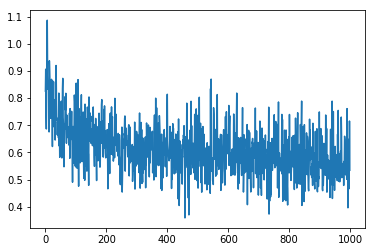

In [19]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.figure()
plt.plot(rank_loss_list)
plt.show()

In [20]:
torch.save(select_net, "qcentric.model")
torch.save(rank_net, "deeprank.model")

In [21]:
select_net_e = torch.load(f='qcentric.model')
rank_net_e = torch.load(f='deeprank.model')

list_gen = ListGenerator(rel_file=Letor07Path+'/relation.test.fold%d.txt'%(letor_config['fold']),
                         config=letor_config)
map_v = 0.0
map_c = 0.0

with torch.no_grad():
    for X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F in \
        list_gen.get_batch(data1=loader.query_data, data2=loader.doc_data):
        #print(X1.shape, X2.shape, Y.shape)
        X1, X1_len, X2, X2_len, Y, F = to_device(X1, X1_len, X2, X2_len, Y, F, device=select_device)
        X1, X2, X1_len, X2_len, X2_pos = select_net_e(X1, X2, X1_len, X2_len, X1_id, X2_id)
        X2, X2_len = utils.data_adaptor(X2, X2_len, select_net, rank_net, letor_config)
        #print(X1.shape, X2.shape, Y.shape)
        pred = rank_net_e(X1, X2, X1_len, X2_len, X2_pos)
        map_o = utils.eval_MAP(pred.tolist(), Y.tolist())
        #print(pred.shape, Y.shape)
        map_v += map_o
        map_c += 1.0
    map_v /= map_c

print('[Test]', map_v)

[./data/letor/r5w/relation.test.fold1.txt]
	Instance size: 13652
List Instance Count: 336
[Test] 0.5042477865174272
